<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression_Object_oriented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [43]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pydicom" || pip install pydicom
!python -c "import dicom2nifti" ||pip install dicom2nifti



from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from google.colab import drive
from datetime import datetime


2024-01-15 12:21:05.950336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 12:21:05.950399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 12:21:05.952371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 12:21:07.743923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [49]:
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/PET_data/ASC-PET-001'
directory='/content/drive/My Drive/PET_data/LOG'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set dataset path

In [79]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
# train_files, val_files =  data_dicts[:20], data_dicts[-5:]
train_files, val_files =  data_dicts[-2:], data_dicts[-1:]

set_determinism(seed=0)


In [80]:
crop_size = (180, 180, 312)  # Adjusted based on my data

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode='bilinear'),
        CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),
    ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode=('bilinear')),
        CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),

    ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 1/1 [00:30<00:00, 30.13s/it]


In [82]:
len(train_ds)

2

image shape: torch.Size([180, 180, 312]), target shape: torch.Size([180, 180, 312])


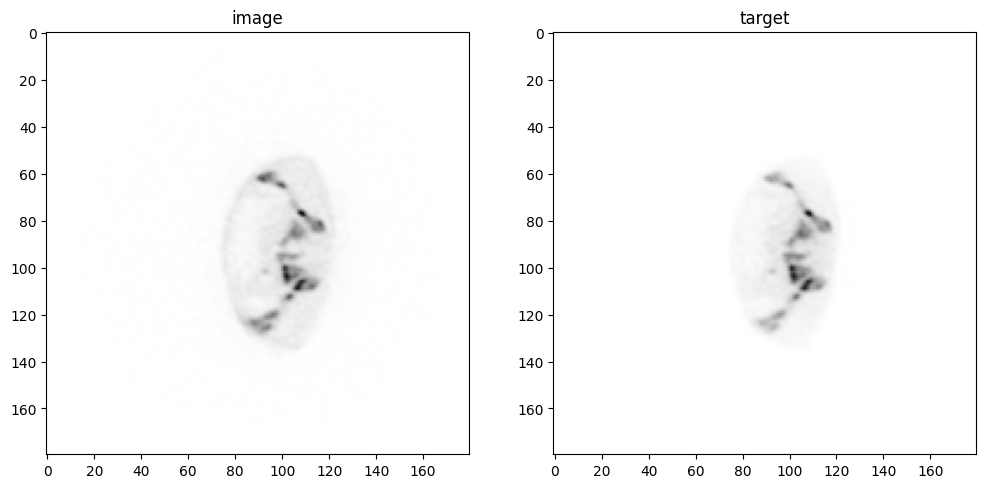

In [47]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 100

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

# **Create Model, Loss, Optimizer**

In [65]:
from datetime import datetime

s = datetime.now()
f"{s.month}-{s.day}-{s.hour}-{s.minute}"

'1-15-14-5'

In [85]:
import os
import datetime
from datetime import datetime


class TrainingLogger:
    def __init__(self, directory):
        self.directory = directory
        self.ensure_directory_exists(self.directory)
        self.log_file = self.create_log_file()

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def create_log_file(self):
        filename = f"{self.directory}/log_{self.get_date()}.txt"
        return open(filename, "w")

    def get_date(self):

        s = datetime.now()
        date = f"{s.month}_{s.day}_{s.hour}_{s.minute}"
        return date

    def log(self, message):
        print(message)
        self.log_file.write(message + "\n")

    def close(self):
        self.log_file.close()



In [105]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_function, max_epochs, val_interval, directory):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.max_epochs = max_epochs
        self.val_interval = val_interval
        self.directory = directory
        self.logger = TrainingLogger(directory)
        self.best_metric = float('inf')
        self.best_metric_epoch = -1


    def log(self):
        self.logger.log(f"train set: {len(train_files)}" + "\n")
        self.logger.log(f"validation set: {len(val_files)}" + "\n")
        self.logger.log(f"max_epochs: {max_epochs}" + "\n")
        self.logger.log(f"val_interval: {val_interval}" + "\n")
        self.logger.log(f"model.channels: {model.channels}" + "\n")




    def train(self):

        for epoch in range(self.max_epochs):
            self.logger.log("-" * 10)
            self.logger.log(f"epoch {epoch + 1}/{self.max_epochs}")

            self.model.train()
            epoch_loss = 0
            step = 0

            for batch_data in self.train_loader:
                step += 1
                inputs, targets = batch_data["image"].to(device), batch_data["target"].to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                train_loss_info = f"{step}/{len(self.train_loader.dataset) // self.train_loader.batch_size}, train_loss: {loss.item():.4f}"
                self.logger.log(train_loss_info)

            # Calculate average loss for the epoch
            epoch_loss /= step
            self.logger.log(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Validation
            if (epoch + 1) % self.val_interval == 0:
                self.model.eval()
                val_loss = 0
                with torch.no_grad():
                    for val_data in self.val_loader:
                        val_inputs, val_targets = val_data["image"].to(device), val_data["target"].to(device)
                        val_outputs = self.model(val_inputs)
                        val_loss += self.loss_function(val_outputs, val_targets).item()

                    val_loss /= len(self.val_loader)
                    self.logger.log(f"Validation loss: {val_loss:.4f}")

                    if val_loss < self.best_metric:
                        self.best_metric = val_loss
                        self.best_metric_epoch = epoch + 1
                        self.save_model()

        self.logger.close()

    def save_model(self):
        model_filename = f"model_{self.logger.get_date()}.pth"
        torch.save(self.model.state_dict(), os.path.join(self.directory, model_filename))
        self.logger.log(f"Saved {model_filename} model, best_metric: {self.best_metric:.4f}, epoch: {self.best_metric_epoch} ")

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

max_epochs = 6
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, max_epochs, val_interval,directory)
trainer.log()
trainer.train()

train set: 2

validation set: 1

max_epochs: 6

val_interval: 2

model.channels: (16, 32, 64)

----------
epoch 1/6
1/0, train_loss: 1.2602
epoch 1 average loss: 1.2602
----------
epoch 2/6
1/0, train_loss: 1.2222
epoch 2 average loss: 1.2222
Validation loss: 0.7948
Saved model_1_15_15_7.pth model, best_metric: 0.7948, epoch: 2 
----------
epoch 3/6
1/0, train_loss: 1.1936
epoch 3 average loss: 1.1936
----------
epoch 4/6
1/0, train_loss: 1.1721
epoch 4 average loss: 1.1721
Validation loss: 0.7913
Saved model_1_15_15_9.pth model, best_metric: 0.7913, epoch: 4 
----------
epoch 5/6
1/0, train_loss: 1.1547
epoch 5 average loss: 1.1547
----------
epoch 6/6
1/0, train_loss: 1.1404
epoch 6 average loss: 1.1404
Validation loss: 0.7885
Saved model_1_15_15_10.pth model, best_metric: 0.7885, epoch: 6 


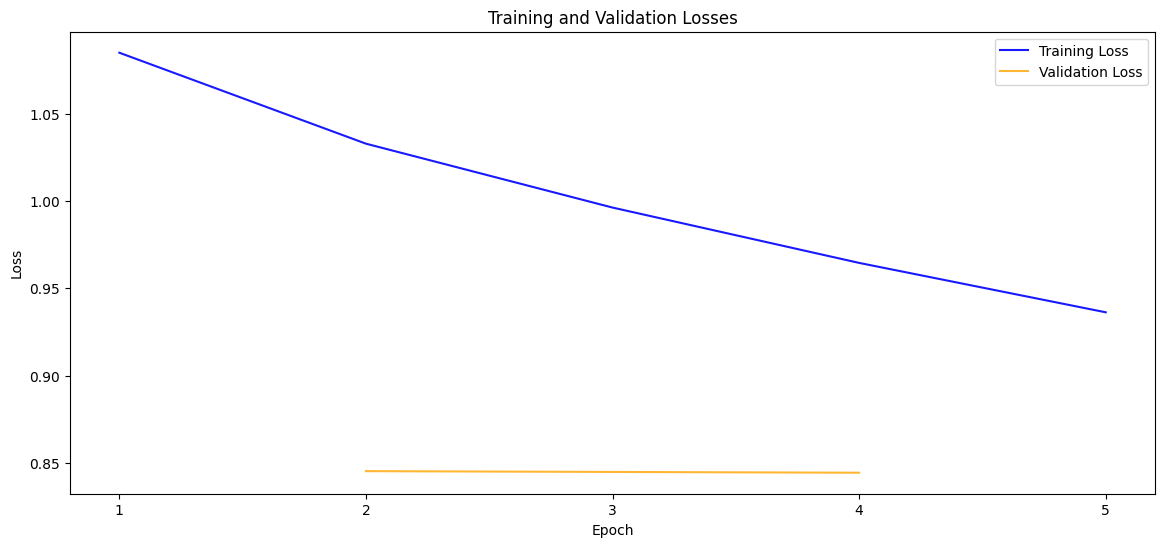

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Function to parse the loss values from the log file
def parse_loss_values(log_filename):
    train_losses = []
    val_losses = []
    with open(log_filename, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file
log_filename = directory + "/training_log_2024-01-15 12:41:38.029635.txt"

train_losses, val_losses = parse_loss_values(log_filename)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 1))  # Adjust the x-axis ticks if needed
plt.show()


In [119]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                last_saved_model = line.split()[1]
    return last_saved_model


log_filepath = directory + '/log_1_15_15_6.txt'


bestmodel_filename = find_last_saved_model(log_filepath)
print(bestmodel_filename)


model_1_15_15_10.pth


In [122]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")


Model file model_1_15_15_10.pth is loading.


100%|██████████| 7/7 [01:44<00:00, 14.87s/it]


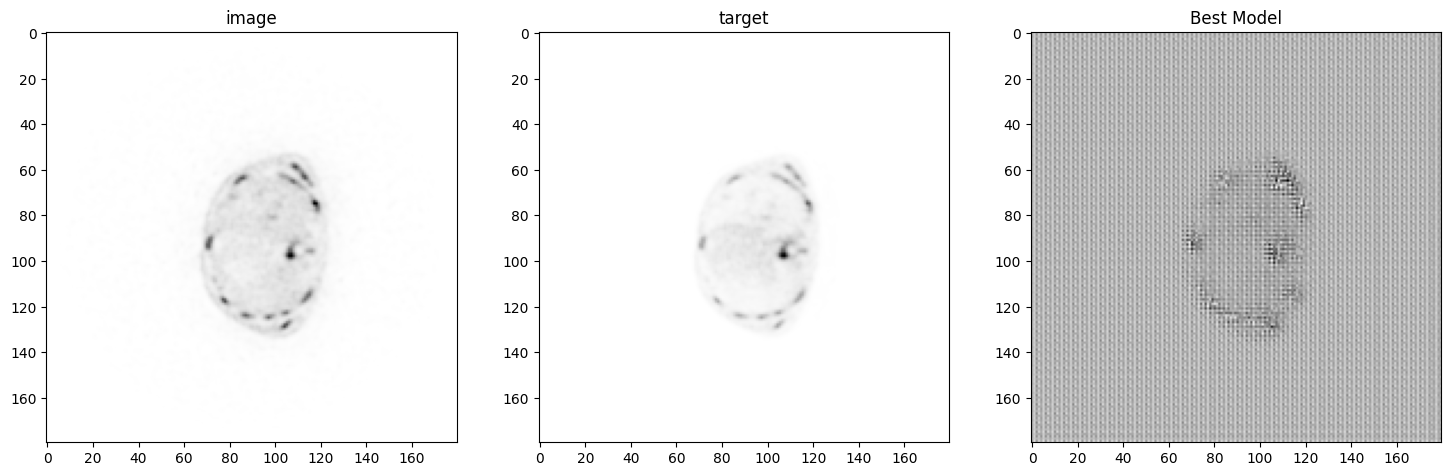

In [123]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook